In [1]:
import os 
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.model_selection import train_test_split


In [3]:
foldername="flowers"

def load_image(foldername):
    x=[]
    y=[]
    for classname in os.listdir(foldername):
        classfolder=os.path.join(foldername,classname)
        if os.path.isdir(classfolder):
            for imgname in os.listdir(classfolder):
                img_path=os.path.join(classfolder,imgname)
                if img_path.lower().endswith((".png", ".jpg", ".jpeg")):
                    img = load_img(img_path, target_size=(128,128), color_mode='rgb')
                    img = img_to_array(img)
                    img=img.astype('float32')/255
                    img = img.flatten()  
                    x.append(img)
                    y.append(classname)
    return np.array(x),np.array(y)

x,y=load_image(foldername)


print(x.shape,y.shape)


(4317, 49152) (4317,)


In [4]:
encoder=LabelEncoder()
y_encoded=encoder.fit_transform(y)
unique=encoder.classes_

outputsize=len(unique)

binarizer=LabelBinarizer()
y=binarizer.fit_transform(y_encoded)

inputsize=x.shape[1]

print(y.shape)

(4317, 5)


In [5]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7,random_state=42)

In [25]:
class MLP:
    def __init__(self,inputsize,outputsize,hiddensize,learningrate):
        self.inputsize=inputsize
        self.outputsize=outputsize
        self.learningrate=learningrate
        self.hiddensize=hiddensize
        self.inputweights=np.random.randn(inputsize,hiddensize)
        self.hiddenweigths=np.random.randn(hiddensize,outputsize)
        self.hiddenbias=np.zeros((1,hiddensize))
        self.outputbias=np.zeros((1,outputsize))

    def sigmoid(self,x):
        return 1/(1+np.exp(-x))
    
    def sigmoid_derivative(self,x):
        return x*(1-x)
    
    def forward(self,input):
        # (1,49152)(49152,10)
        self.hiddenouput=self.sigmoid(np.dot(input,self.inputweights)+self.hiddenbias)
        #(1,10)(10,5)
        self.output=self.sigmoid(np.dot(self.hiddenouput,self.hiddenweigths)+self.outputbias)
        return self.output
    
    def backward(self,input,label):
        #(1,5)
        error=label-self.output
        #(1,5)
        outputdelta=error*self.sigmoid_derivative(self.output)
        #(1,10) (1,5) (10,5)
        hiddendelta=self.sigmoid_derivative(self.hiddenouput)*np.dot(outputdelta,self.hiddenweigths.T)
        #(10,1)(1,5)
        self.hiddenweigths+=self.learningrate*np.dot(self.hiddenouput.T,outputdelta)
        #(49152,1) (1,10)
        self.inputweights+=self.learningrate*np.dot(input.T,hiddendelta)
        self.hiddenbias+=self.learningrate*hiddendelta
        self.outputbias+=self.learningrate*outputdelta

    def train(self,inputs,labels,epochs=5): 
        losses=[]
        for e in range(epochs):
            totalloss=0
            for img,label in zip(inputs,labels):
                img=img.reshape(1,-1)
                output=self.forward(img)
                loss=np.mean((label-output)**2)
                totalloss+=loss
                label=label.reshape(1,-1)
                self.backward(img,label)
            averageloss=totalloss/len(labels) 
            losses.append(averageloss) 
            print(f'Avergae loss for epoch {e+1}/{epochs} is {averageloss:.4f}')
        return losses
    
    def predict(self,input,labels):
        predicted,actual=[],[]
        for (img,label) in zip(input,labels):
            img=img.reshape(1,-1)
            output=self.forward(img)
            predicted.append(np.argmax(output))
            actual.append(np.argmax(labels))
        return predicted,actual 
    

In [26]:
mlp=MLP(inputsize,outputsize,5,0.1)
losses=mlp.train(x_train,y_train)

Avergae loss for epoch 1/5 is 0.1623
Avergae loss for epoch 2/5 is 0.1590
Avergae loss for epoch 3/5 is 0.1578
Avergae loss for epoch 4/5 is 0.1573
Avergae loss for epoch 5/5 is 0.1565


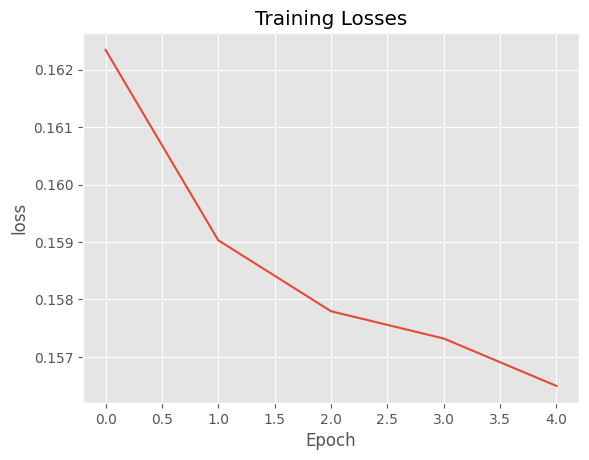

In [27]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Training Losses')
plt.show()

In [28]:
predicted,actual=mlp.predict(x_test,y_test)

In [29]:
def accuracy(actual,predicted):
    accurate=0
    for i in range(len(predicted)):
        if predicted[i]==actual[i]:
            accurate=accurate+1
    return accurate/len(predicted)

print('Accuracy:',accuracy(actual,predicted)*100,'%')

def precision(actual,predicted):
    precision_individual=[]
    for i in range(outputsize):
        tp=0
        fp=0
        for j in range(len(predicted)):
            if (predicted[j]==i and actual[j]==i):
                tp=tp+1
            elif predicted[j]==i:
                fp=fp+1
            if tp+fp==0:
                temp=0
            else:
                temp=tp/(tp+fp)
        precision_individual.append(temp)
    return precision_individual

print('Precision:',precision(actual,predicted))

def recall(actual,predicted):
    recall_individual=[]
    for i in range(outputsize):
        tp=0
        fn=0
        for j in range(len(predicted)):
            if (predicted[j]==i and actual[j]==i):
                tp=tp+1
            elif actual[j]==i:
                fn=fn+1
            if tp+fn==0:
                temp=0
            else:
                temp=tp/(tp+fn)
        recall_individual.append(temp)
    return recall_individual


print('Recall:',recall(actual,predicted))

def f1_score(precision,recall):
    f1score=[]
    for i in range(outputsize):
        if precision[i]+recall[i]==0:
            f1score.append(0)
        else:
            f1score.append((2*precision[i]*recall[i])/(precision[i]+recall[i]))
    return f1score

print('f1-score:',f1_score(precision(actual,predicted),recall(actual,predicted)))
    

Accuracy: 0.15432098765432098 %
Precision: [0.0, 0.0, 0, 0.0, 1.0]
Recall: [0, 0, 0, 0, 0.0015432098765432098]
f1-score: [0, 0, 0, 0, 0.0030816640986132513]


In [30]:
def confusionmatrix(actual,predicted):
    cm=[]
    for i in range(outputsize):
        temp=[]
        for j in range(outputsize):
            temp.append(sum([1 for k in range(len(predicted)) if predicted[k]==j and actual[k]==i]))
        cm.append(temp)
    return cm

cm=confusionmatrix(actual,predicted)
for i in cm:
    print(i)

[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[1, 1289, 0, 4, 2]


In [31]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve,auc

print(classification_report(actual,predicted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       1.00      0.00      0.00      1296

    accuracy                           0.00      1296
   macro avg       0.25      0.00      0.00      1296
weighted avg       1.00      0.00      0.00      1296



c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Confusion Matrix:
[[   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [   1 1289    4    2]]


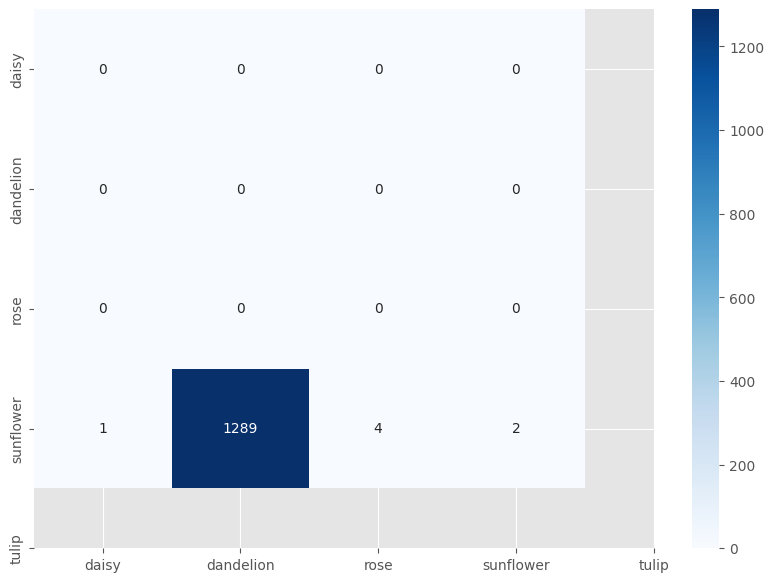

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.style.use('ggplot')

cm = confusion_matrix(actual, predicted)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(10,7))
sns.heatmap(cm,cmap="Blues",annot=True,fmt="d",xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.show()

In [36]:
def predict_prob(input,labels):
        predicted=[]
        for (img,label) in zip(input,labels):
            img=img.reshape(1,-1)
            output=mlp.forward(img) 
            total=0
            for i in range(outputsize):
                total+=np.exp(output[0][i])
            prediction=[]
            for i in range(outputsize):
                prediction.append(np.exp(output[0][i])/total) 
            predicted.append(prediction)
        return np.array(predicted)
        

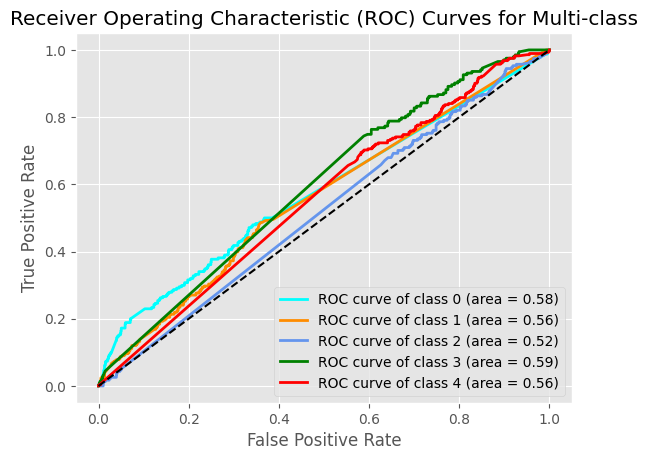

In [45]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = {}
tpr = {}
roc_auc = {}

pred_prob=predict_prob(x_test,y_test) 

# Compute ROC curve and ROC area for each class
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']
for i in range(5):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Multi-class')
plt.legend(loc='lower right')
plt.show()
